In [9]:
!ps aux | grep -i jupy
# !source ~/.bashrc
# !conda activate lcn
# !conda install tensorflow
!which python
# !conda install -c anaconda tensorflow
!echo $PPID

jd1677    291777  0.0  0.0   5796  3028 pts/1    Ss+  15:46   0:00 /bin/bash -c ps aux | grep -i jupy
jd1677    291780  0.0  0.0   5204   728 pts/1    S+   15:46   0:00 grep -i jupy
jd1677   3831120  1.7  0.0 758896 132260 ?       Sl   Oct03  26:09 /usr/bin/python3 /autofs/cluster/scratch/friday/javid/tensorflow_2.13.0-gpu-user-base/bin/jupyter-lab --ip=0.0.0.0 --port=8888 --no-browse --num_gpus=1 --batch_size=32 --model=vgg19 --data_format=NHWC
jd1677   3831260  145  0.5 48533984 4044356 ?    Ssl  Oct03 2191:24 /usr/bin/python3 -m ipykernel_launcher -f /homes/3/jd1677/.local/share/jupyter/runtime/kernel-a00a6ad3-ca5b-4f17-b7a5-36233ded8367.json
jd1677   3831263  0.7  0.2 14569860 1789820 ?    Ssl  Oct03  11:36 /usr/bin/python3 -m ipykernel_launcher -f /homes/3/jd1677/.local/share/jupyter/runtime/kernel-a9150e5b-e707-4109-801e-4a5f933246f1.json
Illegal option --
Usage: /usr/bin/which [-a] args
3831263


In [2]:
# # !ps aux | grep -i jupy
# !pip install -e ../voxelmorph
# !pip install -e ../neurite
# # !pip install wrapt
# # !pip install wrapt
# !pip install scipy
!pip install scipy


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import sys
import tensorflow as tf 

%env CUDA_VISIBLE_DEVICES=0

# !pip install pystrum
# !conda install -y -c conda-forge nibabel
print("TensorFlow version:", tf.__version__)

sys.path.append('/autofs/space/bal_004/users/jd1677/voxelmorph')
sys.path.append('/autofs/space/bal_004/users/jd1677/neurite')

import neurite as ne
print(ne.__file__)

2023-10-02 20:07:47.002332: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


env: CUDA_VISIBLE_DEVICES=0
TensorFlow version: 2.13.0
/autofs/space/bal_004/users/jd1677/neurite/neurite/__init__.py


In [4]:
# !pip install tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import voxelmorph as vxm
import tensorflow as tf


from tensorflow.python.client import device_lib

# !pip install tensorflow-gpu


devices = tf.config.list_physical_devices()
for device in devices:
    print(device.name)

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu.name)

/physical_device:CPU:0
/physical_device:GPU:0
/physical_device:GPU:0


100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


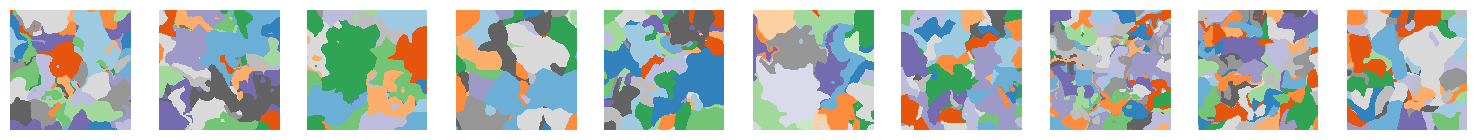

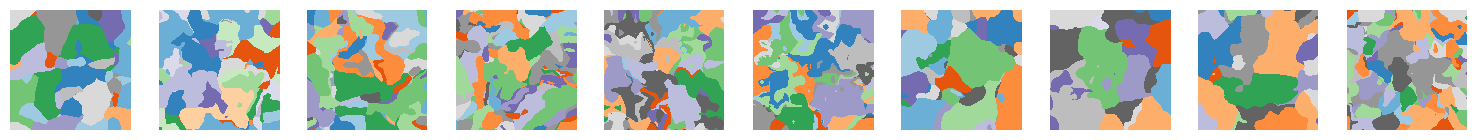

In [6]:
import tensorflow as tf 

in_shape = (256,) * 2
num_dim = len(in_shape)
num_label = 16
num_maps = 20

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    
    # print(im[1,1,1])
    
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab))


# Visualize shapes.
num_row = 2
per_row = 10
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps[i:i + per_row], cmaps=['tab20c'])

/autofs/space/bal_004/users/jd1677/neurite/neurite/tf/models.py:758: UserWarning: model `labels_to_image` is deprecated in favor `labels_to_image_new`
  warnings.warn('model `labels_to_image` is deprecated in favor `labels_to_image_new`')
2023-10-03 13:02:03.804159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 0s 27ms/step


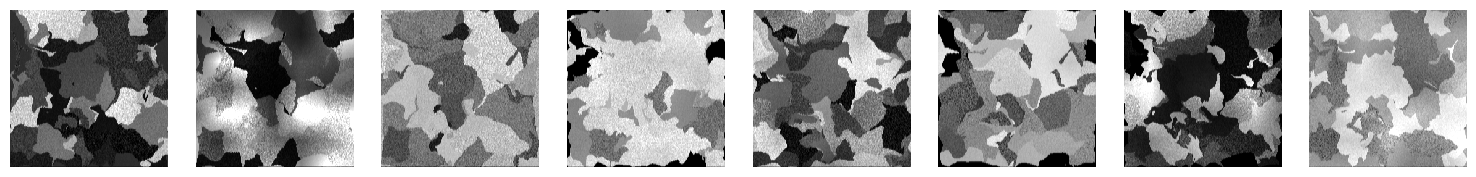

In [8]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)

gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)

tf.get_logger().setLevel('ERROR')

# @tf.autograph.experimental.do_not_convert

# Test repeatedly for single input.
num_gen = 8
input = np.expand_dims(label_maps[0], axis=(0, -1))
slices = [gen_model_1.predict(input)[0] for _ in range(num_gen)]
ne.plot.slices(slices);

In [9]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256] * 4, [256] * 8),
    reg_field='warp',
)


# Model for optimization.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)


# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [10]:
# Train model for a few epochs. Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1,
    same_subj=True,
    flip=True,
)

In [11]:
# Conform test data.
def conform(x, in_shape=in_shape):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = np.squeeze(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

# OASIS Sample Data


In [5]:
import nibabel as nib
slice_norm = nib.load("neurite-oasis.2d.v1.0/OASIS_OAS1_0169_MR1/slice_norm.nii.gz")
slice_orig = nib.load("neurite-oasis.2d.v1.0/OASIS_OAS1_0169_MR1/slice_orig.nii.gz")
slice_seg24 = nib.load("neurite-oasis.2d.v1.0/OASIS_OAS1_0169_MR1/slice_seg24.nii.gz")
slice_seg4 = nib.load("neurite-oasis.2d.v1.0/OASIS_OAS1_0169_MR1/slice_seg4.nii.gz")

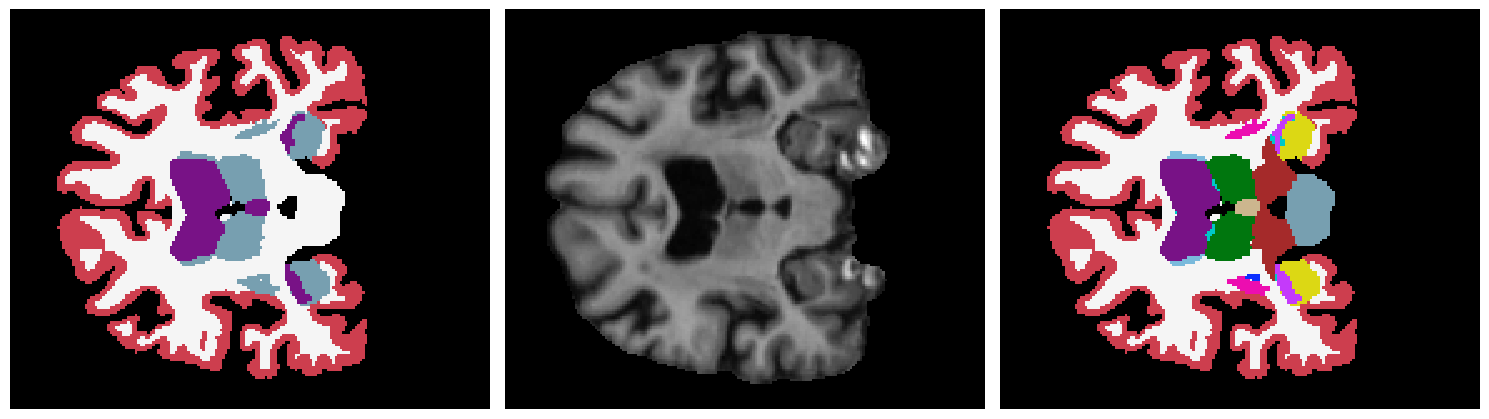

2.13.0


In [13]:
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne

import voxelmorph as vxm

slice_norm_data = slice_norm.get_fdata()
slice_orig_data = slice_orig.get_fdata()
slice_seg24_data = slice_seg24.get_fdata()
slice_seg4_data = slice_seg4.get_fdata()

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import csv

def read_colors_from_csv(filepath):
    colors = []
    with open(filepath, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in spamreader:
            if len(row):
                tokens = row[0].split()
                if tokens[0].isnumeric():
                    colors.append((int(tokens[2])/255.,int(tokens[3])/255.,int(tokens[4])/255.))
    return colors
        
def load_colormap_from_file(filepath):
    # Load the RGB values from a file
    colors = read_colors_from_csv(filepath)#, delimiter='     ')
    return colors

custom_cmap1 = mcolors.ListedColormap(load_colormap_from_file('neurite-oasis.2d.v1.0/seg4_labels.txt'))
custom_cmap2 = mcolors.ListedColormap(load_colormap_from_file('neurite-oasis.2d.v1.0/seg24_labels.txt'))


ne.plot.slices(slices_in=(slice_seg4_data,slice_norm_data, slice_seg24_data),cmaps=[custom_cmap1,'gray',custom_cmap2])

print(tf.__version__)


<class 'tuple'>
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 2s 2s/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 43ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 32ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 39ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 39ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 43ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 44ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 35ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 39ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 40ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [==============================] - 0s 34ms/step
(160, 192, 1) (1, 160, 192, 1, 1)
1/1 [=

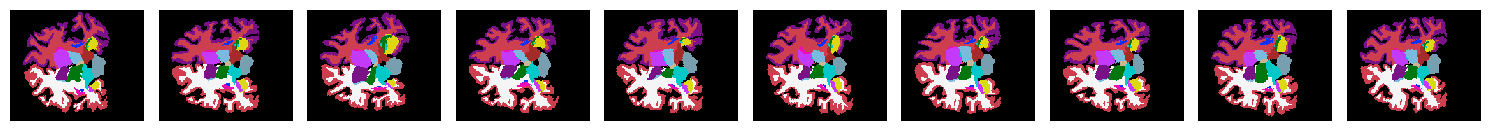

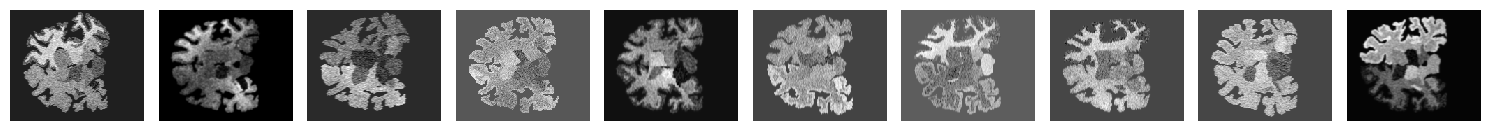

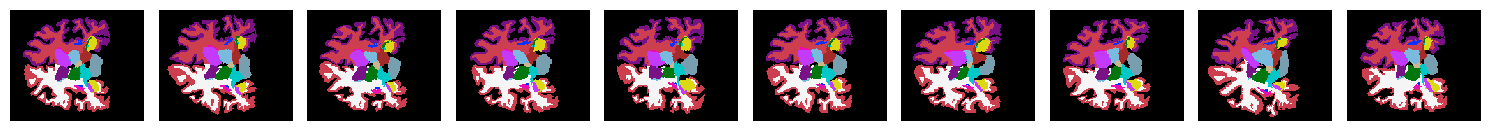

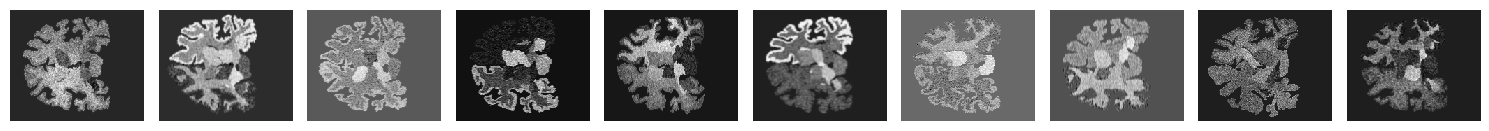

In [7]:
import neurite as ne
import sys

import tensorflow as tf
import os



in_shape = (160,192)
num_dim = len(in_shape)
num_label = 25
n_classes=25
num_maps = 20
input_image = slice_seg24_data
num_gen=20
num_row = 2
per_row = 10

print(type(in_shape))
gen_arg = dict(
        in_shape=in_shape,
        labels_in=np.unique(input_image).astype(int),#np.unique(input_image),
        warp_min=0.01,
        warp_max=2,
        zero_background=1
    )


gen_model_1 = ne.models.labels_to_image_new(**gen_arg, id=1)

slices= []
maps=[]

# with tf.device('/CPU:0'):
for _ in range(num_gen):
    input = np.expand_dims(input_image, axis=(0, -1))
    print(input_image.shape,input.shape)
    model_1, label_map = gen_model_1.predict(input)

    slices.append(np.squeeze(model_1,0))
    labels = np.squeeze(label_map,0)
    maps.append(labels)

print(slices[0].shape,maps[0].shape)
for i in range(0, num_row * per_row, per_row):
    a = np.argmax(maps[i:i + per_row],axis=-1)
    ne.plot.slices(list(a), cmaps=[custom_cmap2])
    ne.plot.slices(slices[i:i + per_row])

<!-- ### !conda remove voxelmorph
import voxelmorph as vxm

print(np.unique(input_image)) -->

In [ ]:
# !pip install -q git+https://github.com/adalca/neurite.git@dev

In [ ]:
print(input_image.shape)

# Tarin a U-Net

In [21]:
import numpy as np
import tensorflow as tf
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def dice_coefficient(y_true, y_pred):
    # Convert y_true to float32
    y_true = tf.cast(y_true, tf.float32)
    
    # Add a small epsilon to avoid zero division error
    epsilon = 1e-6
    
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Compute Dice coefficient
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon)



def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

x_data = np.array(slices)
y_data = np.array(maps)



x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

def one_hot_encode(y, num_classes):
    return tf.keras.utils.to_categorical(y, num_classes)

from keras.callbacks import Callback


class PrintEvery10Epochs(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print(f"Epoch {epoch}/{self.params['epochs']}")
            print(f"Loss: {logs['loss']:.4f}")
            print(f"Dice Coefficient: {logs['dice_coefficient']:.4f}")

def dice_coefficient(y_true, y_pred):
    dice = ne.tf.metrics.Dice()  # you can pass any arguments if you want different configurations
    return dice.mean_dice(y_true, y_pred)


def dice_loss(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
        tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return 1-dice
    
def dice_coefficient(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
    tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return dice

print_every_10_epochs_callback = PrintEvery10Epochs()

input_shape = x_train[0].shape  # Assuming x_train is a numpy array or a list
unet_model = models.unet(input_shape=(160, 192, 1), nb_features=64, nb_labels=25, nb_levels=3, conv_size=4)



NameError: name 'maps' is not defined

In [ ]:
# # ... [rest of your code]
# import keras
# from keras.utils.generic_utils import Progbar
# from keras.callbacks import Callback
# from contextlib import redirect_stdout




# lr = 0.001  # Set your desired learning rate here
optimizer = Adam()

unet_model.compile(optimizer=optimizer, loss=dice_loss, metrics=[dice_coefficient])  # You can add more metrics if needed

            
def one_hot_encode(y, num_classes):
    return tf.keras.utils.to_categorical(y, num_classes)



hist = unet_model.fit(
    x_train, y_train, 
    batch_size=10, 
    epochs=200, 
    validation_split=0.2,
    verbose=0, 
    callbacks=[print_every_10_epochs_callback]
)


In [ ]:
print(x_train.shape,y_train.shape)
# print(y_train[0][100][85:120])
plt.plot(hist.epoch, hist.history['loss'], '.-');
plt.xlabel('Epoch');
plt.ylabel('Loss');

In [ ]:
loss, dice_coeff = unet_model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Dice Coefficient: {dice_coeff:.4f}")
# print(f"Validation Accuracy: {accuracy:.4f}")

# Prediction
predictions = unet_model.predict(x_val)

In [ ]:
# y_val_onehot_argmax = np.argmax(predictions, axis=-1)
# y_val_orig_onehot_argmax = np.argmax(y_val, axis=-1)
# x_train_orig_onehot_argmax = np.squeeze(x_val, axis=-1)
# ne.plot.slices(slices_in=(y_val_onehot_argmax[0],x_train_orig_onehot_argmax[0],y_val_orig_onehot_argmax[0]))#,cmaps=[custom_cmap2,'gray',custom_cmap2])

# Prediction
predictions = unet_model.predict(x_val)

# Convert one-hot encoded predictions and ground truth back to label maps
y_pred_argmax = np.argmax(predictions, axis=-1)
y_true_argmax = np.argmax(y_val, axis=-1)

# Plot
ne.plot.slices(slices_in=(y_pred_argmax[0], np.squeeze(x_val[0], axis=-1), y_true_argmax[0]),cmaps=[custom_cmap2,'gray',custom_cmap2])


# Combined Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib

import numpy as np

import os


import random
num_gen = 20

def dice_coefficient(y_true, y_pred):
    dice = ne.tf.metrics.Dice()  # you can pass any arguments if you want different configurations
    return dice.mean_dice(y_true, y_pred)


def dice_loss(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
        tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return 1-dice
    
def dice_coefficient(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
    tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return dice

def one_hot_encode_image(img, depth=25):
    img = tf.convert_to_tensor(img)
    
    one_hot_img = tf.one_hot(tf.cast(img[..., 0], tf.int32), depth=depth)
    
    return one_hot_img

unique_random_numbers = random.sample(range(1, 401), num_gen)

# Load files only if they exist
slice_seg24_list = []
for i in unique_random_numbers:
    file_path = "neurite-oasis.2d.v1.0/OASIS_OAS1_"+str(i).zfill(4)+"_MR1/slice_seg24.nii.gz"
    if os.path.exists(file_path):
        img = nib.load(file_path)
        img = img.get_fdata()

        # print(len(np.unique(img).astype(int)))
        slice_seg24_list.append(img)
    else:
        continue
        
slice_seg24_array = np.array(slice_seg24_list)

# print(slice_seg24_array[0].shape)
def my_generator(label_maps, batch_size=1, same_subj=False, flip=False):
    in_shape = label_maps[0].shape
    num_dim = len(in_shape)
    void = np.zeros((batch_size, *in_shape), dtype='float32')
    rand = np.random.default_rng()
    prop = dict(replace=False, shuffle=False)
    while True:
        ind = rand.integers(len(label_maps), size=2 * batch_size)
        x = [label_maps[i] for i in ind]
        if same_subj:
            x = x[:batch_size] * 2
        x = np.stack(x)[..., None]

        if flip:
            axes = rand.choice(num_dim, size=rand.integers(num_dim + 1), **prop)
            x = np.flip(x, axis=axes + 1)

        src = x[:batch_size, ...,0]
        y = np.array(void)
        yield src, y
        

in_shape = (160,192)
input_image = slice_seg24_array[1]
# print(input_image.shape)


gen_arg = dict(
        in_shape=in_shape,
        labels_in=np.unique(input_image).astype(int),#np.unique(input_image),
        warp_min=0.01,
        warp_max=2,
        zero_background=1
    )

# print(np.unique(input_image).astype(int))
slices= []
maps=[]

unet_model = models.unet(input_shape=(160, 192, 1), nb_features=64, nb_labels=25, nb_levels=3, conv_size=4)


gen_model_1 = ne.models.labels_to_image_new(**gen_arg, id=1)
# print(gen_model_1.input.shape)
input_img = Input(shape=(160, 192,1))
# print(input_img.shape)

generated_img, y = gen_model_1(input_img)

# Pass the generated image directly into the unet_model
segmentation = unet_model(generated_img)

# Create the combined model
combined_model = Model(inputs=input_img, outputs=segmentation)
# print(y.shape,segmentation.shape)
combined_model.add_loss(dice_loss(y, segmentation))

combined_model.summary()

combined_model.compile(optimizer="adam")#, metrics=[dice_coefficient])
# print(input_image.shape)

gen  = my_generator([input_image],batch_size=1, same_subj=False, flip=False)
hist = combined_model.fit(gen, epochs=200, verbose=1)#, callbacks=[print_every_10_epochs_callback])


25
25
25
24
23
25
25
25
25
25
25
25
23
25
25
25
25
24
using final_pred_activation softmax for unet
(None, 160, 192, 1)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 192, 1)]        0         []                            
                                                                                                  
 model_4 (Functional)        [(None, 160, 192, 1),        0         ['input_2[0][0]']             
                              (None, 160, 192, 25)]                                               
                                                                                                  
 unet (Functional)           (None, 160, 192, 25)         396185    ['model_4[0][0]']             
                                                                        

KeyboardInterrupt: 

In [ ]:
%debug

# Testing on Fetal fMRI

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

img = nib.load("fetal-fmri/sub-2006/ses-T1/func/sub-2006_ses-T1_task-rest_bold.nii.gz")


In [ ]:
first_volume = img.slicer[..., 0].get_fdata()

In [ ]:
print(first_volume.shape)

In [ ]:
# Visualizing axial slices
fig, ax = plt.subplots(5, 5, figsize=(15, 15))

for i in range(25):
    ax[int(i/5), i%5].imshow(first_volume[:, :, int(i * first_volume.shape[2] / 25)], cmap="gray")
    ax[int(i/5), i%5].axis('off')

plt.show()